In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10, 8) # set default figure size, 10in by 8in

In [7]:
import tensorflow as tf

print("is gup available? ", tf.test.is_gpu_available())
print("")

# check which devices tensorflow has recognized and is using
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

is gup available?  False

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3968081787948442173
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9660448067338175745
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
from keras import layers
from keras import models
from keras import optimizers

Using TensorFlow backend.


## Visualizing what convnets learn

One drawback of NN and deep learning machine learning models, is that they are "black boxes", that can sometimes
be difficult to understand the representations and models they learn to solve a problem.  However, convnets
are a bit of a special case, since the feature/filters learned are visual maps, they are easier for use to
visualize and understand what solutions have been learned by the systems.

Here we look at some examples of visualizing the trained convnet feature layers, and their representations.  We
look at:
- Visualizing intermediate convnet outputs (intermediate activations).
- Visualizing convnet filters
- Visualizing heatmaps of class activation in an image


### Visualizing intermediate activations

In this visualization, we are displaying the feature maps (or filters) that are output by convolution
(and/or pooling) layers, given a certain input.  This gives insight into an one particular input is
decomposed into different filters.

In this example, we are reusing the saved model from section 5.2.  If you recall, this model was the result
of training a convnet completely from scratch (we did not use any pre-trained models).

In [8]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary() # as a reminder






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
__________________________________________________

We will need some particular image. Here we get an image that we didn't train with, from the test set. You can of course try the results on different input images.


In [11]:
import os, shutil

# change these paths to reflect where the original files are, and where  you want
# the new small dataset to be generated into
original_dataset_dir = '/home/dash/tmp/train'
base_dir = 'data/cats_and_dogs_small'


# likewise set up subdirectories for the train, validation and test set data we extract
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# and subdirectories under each of these for cats and dogs pictures for each of the
# train, validation and test data
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [12]:
from keras.preprocessing import image

img_path = os.path.join(test_cats_dir, 'cat.1700.jpg')

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.0 # model was trained on input that was scaled by 1/250 to range [0, 1]

print(img_tensor.shape)

(1, 150, 150, 3)


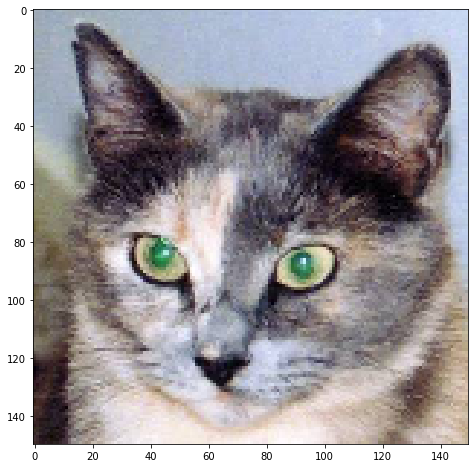

In [13]:
# display the picture
plt.imshow(img_tensor[0]);

We need to create a Keras model that takes an image (or batchs of images) as input, and outputs the activation of
all convolution and pooling layers.  We use the Keras class `Model` instead of `Sequential` for this.  The `Model`
allows a model with multiple outputs, which we need so we can extract the tensors of the layers to visualize.

In [14]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # only extracts output of the top 8 convolution & pooling layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # creates a model that returns these outputs given an input


A lot of stuff is hidden here of what is happenning.  But basically this is all we need in order to get all of the
outputs for our trained model conv & pool layers, given an input picture.  This `Model` has one input, and
eight separate output tensors: one output tensor per layer activation.

For instance, this is the activation of the first convolution layer.  Notice that `predict` returns a (regular
python) list of 8 results, which will be the tensor outputs from each of the 8 layers we specified.

In [15]:
activations = activation_model.predict(img_tensor)

print(type(activations))
print(len(activations))

first_layer_activation = activations[0]
print(first_layer_activation.shape)

<class 'list'>
8
(1, 148, 148, 32)


We can visualize the results of any of the output filters of this first layer by appropriately slicing and
plotting the resulting image.

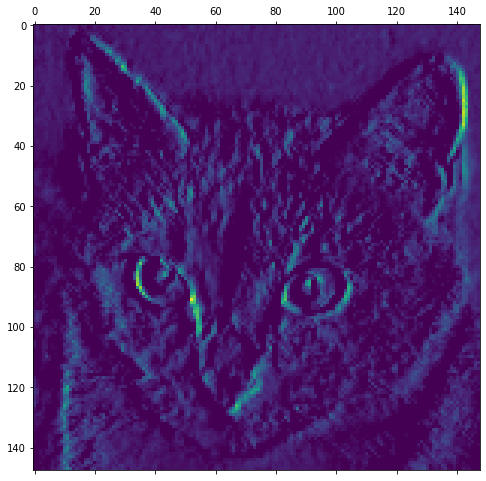

In [16]:
# show image of the fourth channel or filter
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

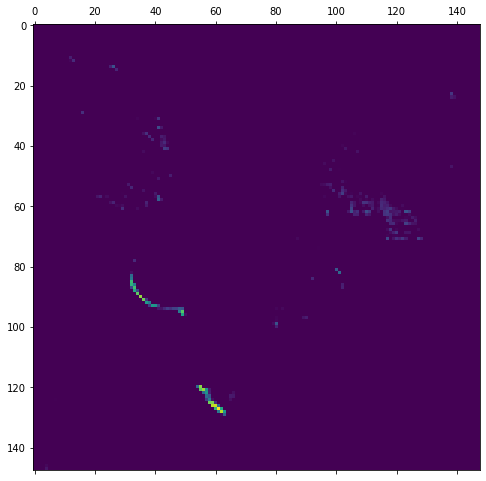

In [17]:
# show image of the 7 channel or filter
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

The results we get will differ from the textbook, because each time we run we start with different initial
random weights, and thus the filter learned each time will differ.  I got something similar to the
textbook for the first filter.  Here greens and yellows represent high activation, and blue is low.  So
you might find things like horizontal, vertical lines, or lines of some particular angle being highlighted.
You might spot other things like color splotches (which are useful to find eyes, for example).

We can write some code to plot out all of these filters, for all of the 8 layers, so we can see all of the
resulting tensor outputs in response to this input picture.

/home/dash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


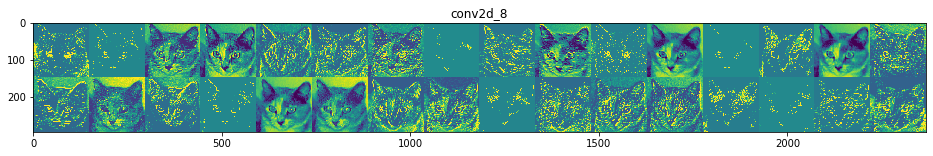

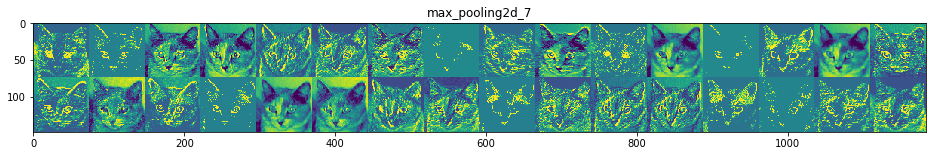

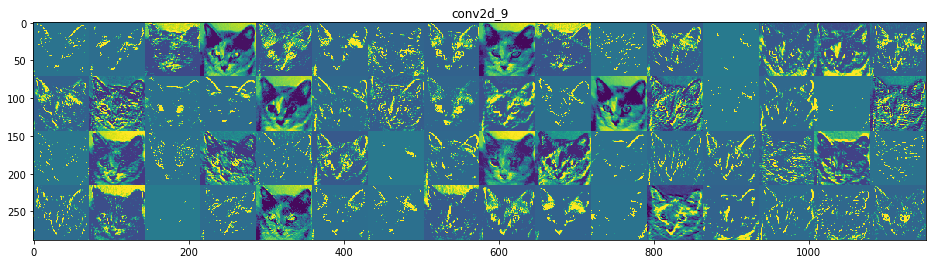

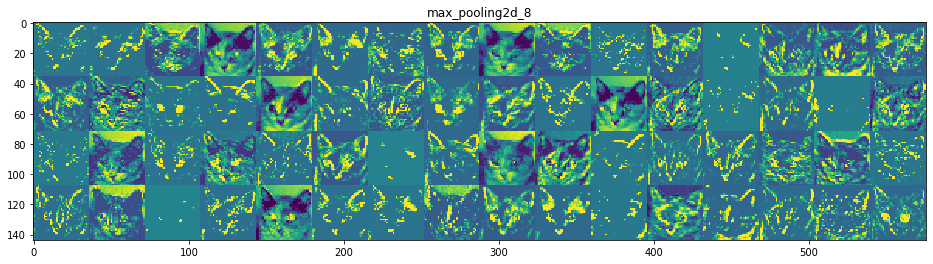

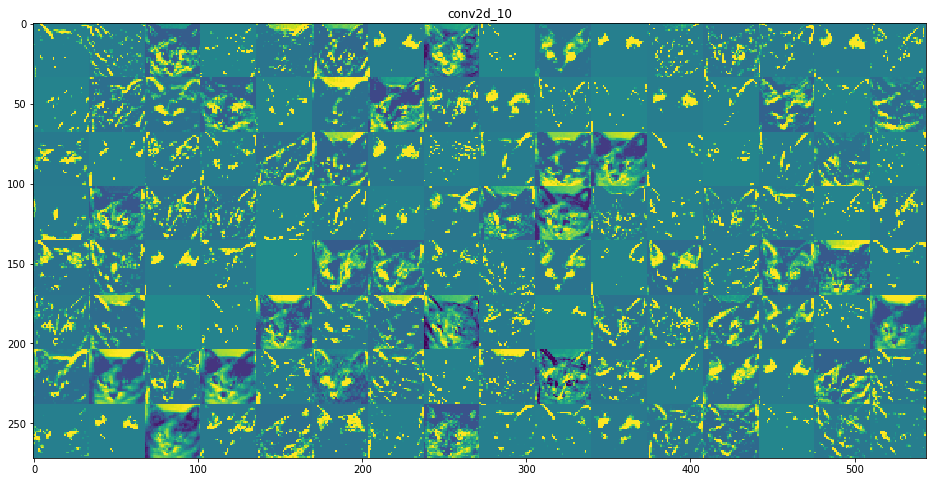

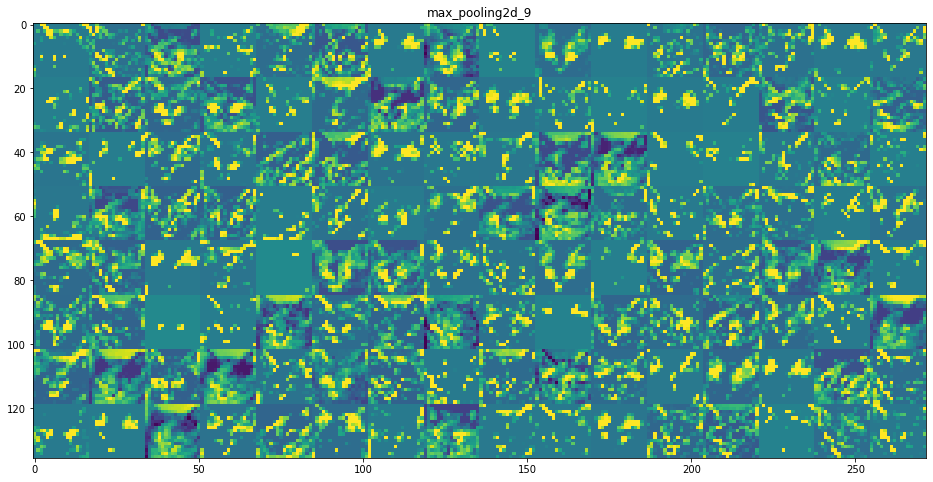

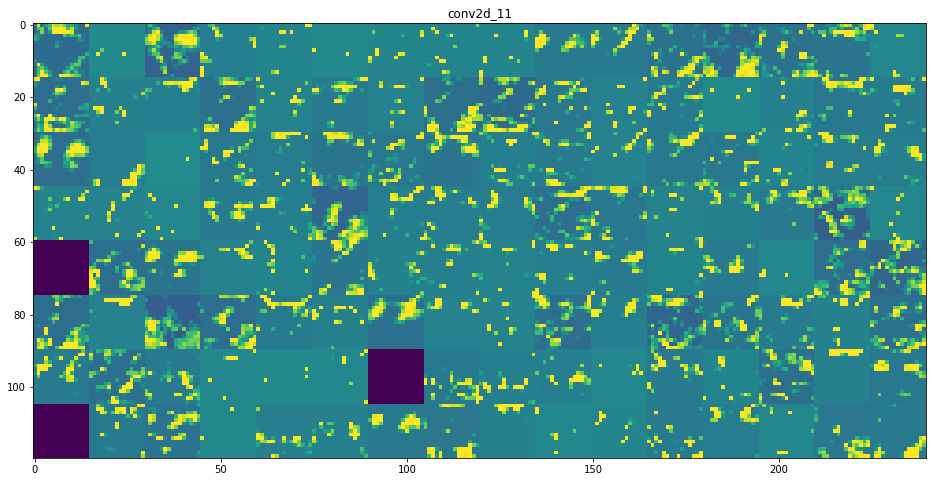

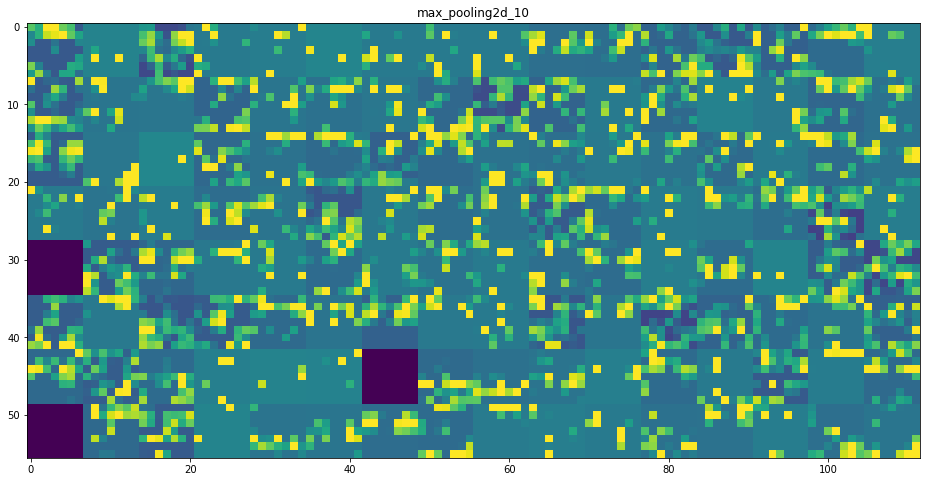

In [18]:
# names of layers so we can indicate in out output
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
# can adjust as needed for your display
images_per_row = 16

# outer loop goes through each layer one by one, displaying all feature
# maps output by the layer
for layer_name, layer_activation in zip(layer_names, activations):
    # number of features or filters in the feature map
    n_features = layer_activation.shape[-1]
    
    # The feature map has shape (i, size, size, n_features)
    size = layer_activation.shape[1]
    
    # tiles the activation channels in this matrix
    # we create an empty matrix, then copy/tile small versions of output into it for display
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # Tiles each filter into the big horizontal display_grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # post-process the features to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            
            # we are converting back to [0, 255] range here, because of how we are plotting image
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            # copies this image into our display_grid to be plotted all together
            display_grid[col * size : (col + 1) * size, 
                         row * size : (row + 1) * size] = channel_image
            
    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

A few things to note.

### Visualizing convnet filters



In [19]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

58892288/58889256 [==============================] - 221s 4us/step


In [20]:
grads = K.gradients(loss, model.input)[0]

In [21]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [22]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_alue = iterate([np.zeros((1, 150, 150, 3))])

In [23]:
# starts from a gray image with some noize
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.0

step = 1.0
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [24]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [25]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.0
    
    step = 1.0
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

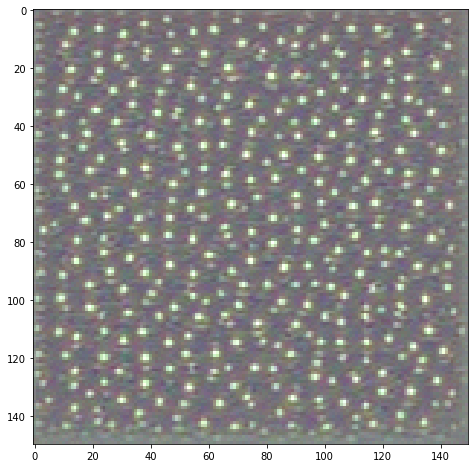

In [26]:
plt.imshow(generate_pattern('block3_conv1', 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


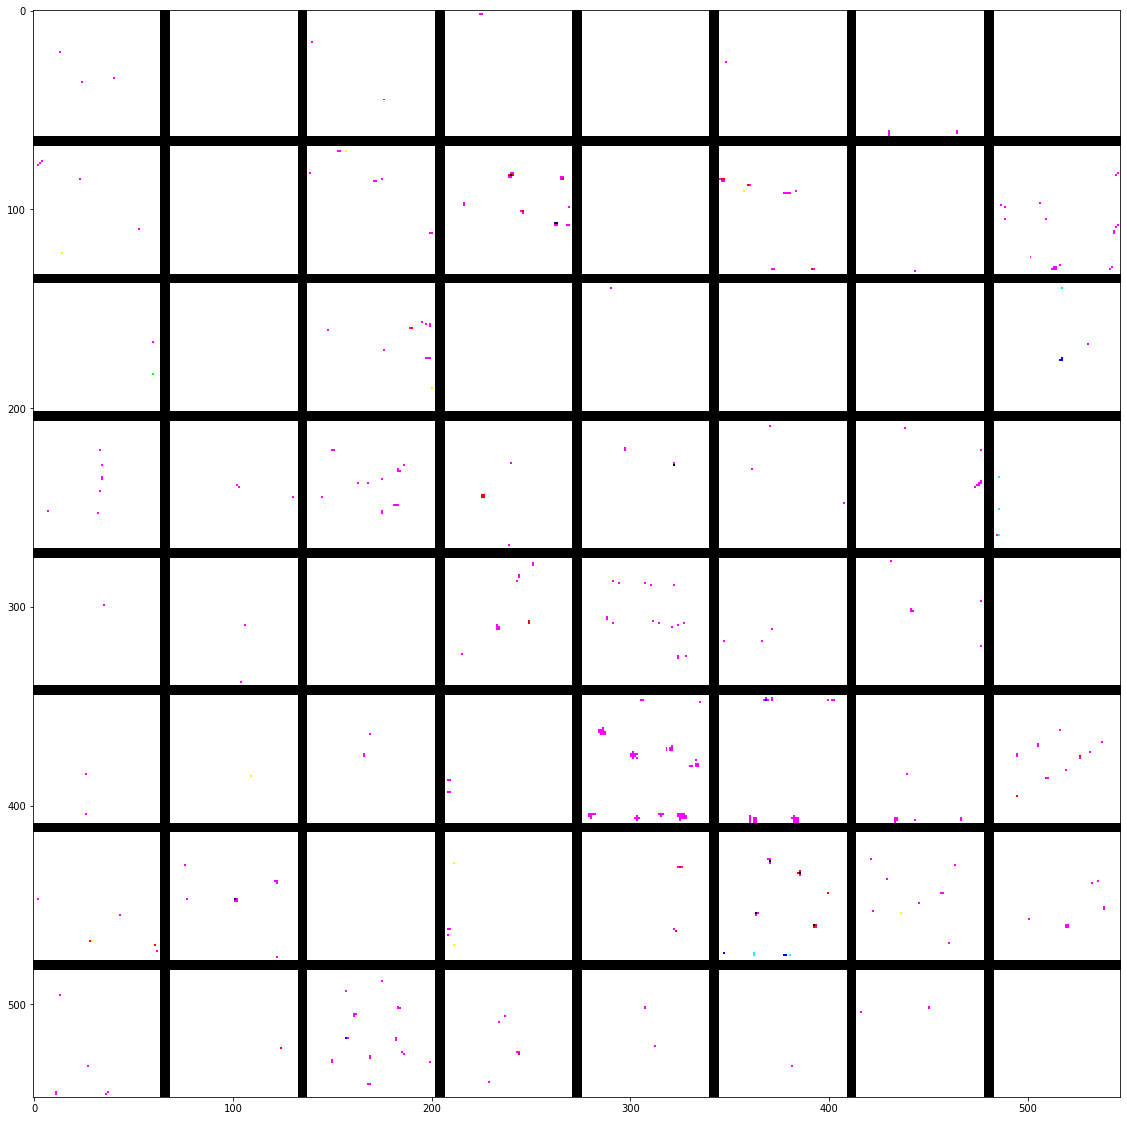

In [27]:
layer_name = 'block4_conv1'
size = 64
margin = 5

# empty (black) image to store results
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

# iterates over the rows of the results grid
for i in range(8):
    # interates over the columns
    for j in range(8): 
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start : horizontal_end,
                vertical_start   : vertical_end,
                :] = filter_img
        
plt.figure(figsize=(20, 20))
plt.imshow(results)

### Visualizing heatmaps of class activation

In [28]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 1014s 2us/step


In [29]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'data/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

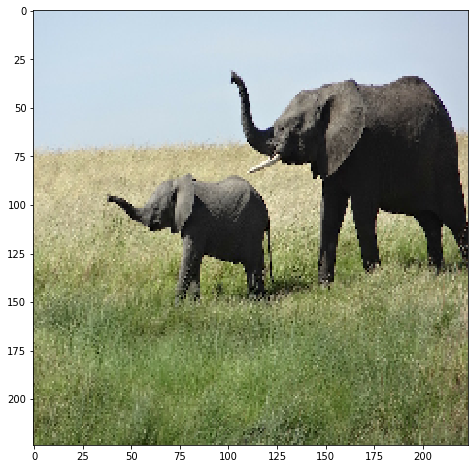

In [30]:
plt.imshow(img)

In [31]:
preds = model.predict(x)
print('predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 1s 14us/step
predicted: [('n02504458', 'African_elephant', 0.9094204), ('n01871265', 'tusker', 0.08618348), ('n02504013', 'Indian_elephant', 0.0043546204)]


In [32]:
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

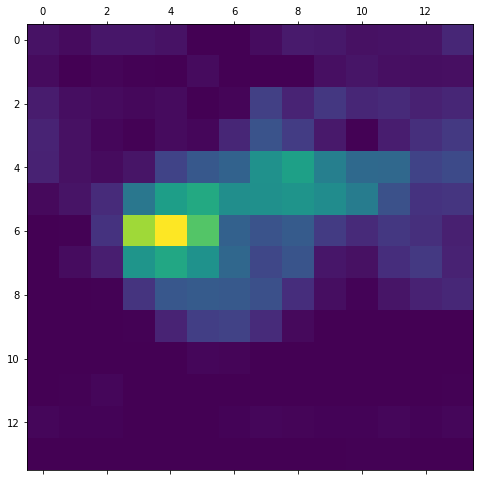

In [33]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
# may need to install OpenCV  $ conda install -c menpo opencv
import cv2

# use cv2 to load the original image
img = cv2.imread(img_path)

# resizes the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# converts the heatmap to RGB
heatmap.uint8(255 * heatmap)

# applies the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * o.4 + img

# cv2.imwrite('data/elephant_cam.jpg', superimposed_img)
plt.imshow(superimposed_img)